<a href="https://colab.research.google.com/github/guilhermeaugusto9/sigmoidal/blob/master/05_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img alt = "Colaboratory logo" width = "15%" src = "https://github.com/guilhermeaugusto9/sigmoidal/raw/master/03%20-%20Outros/Logo%20Guilherme%20Augusto.png"></center>

#### **Data Science e Análise de dados**
*by [Guilherme Augusto](https://github.com/guilhermeaugusto9)



# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da base de clientes. 
Em serviços como Netflix Spotify, Amazon Prime e outros que utilizamos, ela representaria a taxa de clientes que cancelam a assinatura em um determinado período de tempo.

<p align=center>
<img src="https://www.evergent.com/wp-content/uploads/2018/02/blog_3goldfish2.jpg" width="100%"></p>

Avaliar o serviço prestado por esta métrica é essencial para qualquer negócio, pois uma taxa muito elevada de Churn indica que existe um problema a ser resolvido.

Reter clientes é , segundo várias pesquisas , mais barato que adquirir novos clientes. Sendo assim , é essencial para  a boa saúde financeira das empresas manter o churn rate o mais baixo possível.

A fórmula básica para se calcular esta taxa é descrita como :

<p align=center>
<img src="https://s3.amazonaws.com/wootric-marketing/wp-content/uploads/2019/07/Customer-Churn-Rate.png" width="100%"></p>

Seguiremos para esta análise um pequeno roteiro, inspirado no livro: Hands‑On Machine Learning with Scikit‑Learn, Keras, and TensorFlow, lembramos que a metodologia completa foi extremamente simplificada pois se trata este de um projeto apenas ilustrativo de como seria um algorítmo real utilizado em uma empresa.



*   Aquisição dos dados
*   Análise exploratória dos Dados
*   Preparação dos dados
*   Modelo de Machine Learning
*   Otimização dos hiperparâmetros
*   Conclusões



# Aquisição dos dados


Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [ ]:
## Pacotes necessários
!pip install scikit-plot -q

!pip install imbalanced-learn -q

# import warnings filter

from warnings import simplefilter

# ignore all future warnings

simplefilter(action='ignore', category=FutureWarning)

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report

from scikitplot.metrics import plot_confusion_matrix, plot_roc

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

from lightgbm import LGBMClassifier

from sklearn.linear_model import SGDClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Gerar seed para reprodutibilidade e importar os dados

  # random seed
np.random.seed(88)

  # importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

  #visualizar as 5 primeiras universidades
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


As 5 primeiras entradas  nos mostram claramente como é a base de dados, apesar de não se explícito o significado de cada coluna, mas é possível fazer inferências lógicas.

In [ ]:
print("Linhas:\t\t{}".format(df.shape[0]))
print("Colunas:\t{}".format(df.shape[1]))

Linhas:		7043
Colunas:	21


Como se verifica abaixo, o dataset é composto de 7043 entradas e 21 variáveis

## Análise Exploratória dos Dados

A fim de começar este projeto, irei verificar a integridade e usabilidade do dataset. 

Para isso, deixarei impresso a quantidade de dados ausentes, os nomes das colunas, os tipos de variáveis por coluna e os valores únicos por coluna. Essa última, especificamente, vai auxiliar na identificação de variáveis potencialmente categóricas.

In [ ]:
print("Dados ausentes (total):\t{}\n".format(df.isnull().sum().values.sum()))


Dados ausentes (total):	0



In [ ]:
print(df.isnull().sum() / df.shape[0])


customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64


In [ ]:
print("\nNomes das features:\n{}\n".format(df.columns.values))


# Sempre uso essa estratégia para poder usar os nomes das colunas com mais facilidade em outros processos do projeto.


Nomes das features:
['customerID' 'gender' 'SeniorCitizen' 'Partner' 'Dependents' 'tenure'
 'PhoneService' 'MultipleLines' 'InternetService' 'OnlineSecurity'
 'OnlineBackup' 'DeviceProtection' 'TechSupport' 'StreamingTV'
 'StreamingMovies' 'Contract' 'PaperlessBilling' 'PaymentMethod'
 'MonthlyCharges' 'TotalCharges' 'Churn']



In [ ]:
print("Valores únicos (por coluna):\n{}\n".format(df.nunique()))


Valores únicos (por coluna):
customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64



In [ ]:
print("Tipos de Variáveis (por coluna)\n{}".format(df.dtypes))

Tipos de Variáveis (por coluna)
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


Desta análise exploratória inicial detectamos algumas informações relevantes por exemplo:

  * A coluna que queremos prever é a 'Churn'

  * A coluna `TotalCharges` deveria ser um `float`, mas está como `string`. o que pode indicar a presença de dados ausentes.

  * Várias features precisam ser codificadas para valores numéricos.


In [ ]:
#Realizando a correção da coluna TotalCharges
def converter_str_float(entrada):
    try:
        return float(entrada)
    except ValueError:
        return np.nan

# criar cópia do dataframe
df_clean = df.copy()

# remover coluna custumerID
df_clean.drop("customerID", axis=1, inplace=True)

# converter as strings de TotalCharges para float
df_clean["TotalCharges"] = df_clean["TotalCharges"].apply(converter_str_float)

# substituir os dados ausentes pelo valor da mediana
TotalChargesMedian = df_clean.TotalCharges.median()
df_clean["TotalCharges"].fillna(TotalChargesMedian, inplace=True)

In [ ]:
# Verificando a presença de outliers

df_clean.describe() 

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


A princípio não existe indícios de outliers então iremos prosseguir com a análise verificando se existe desbalançeamento de classes em nossa variável alvo. 

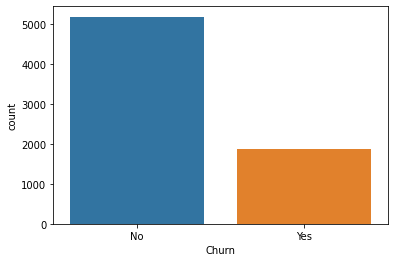

In [ ]:
sns.countplot(df.Churn)

Verificamos que existe sim ,desbalanceamento , o que é algo normal para o caso em análise, pois espera-se que uma empresa apresente uma quantidade de clientes se mantenham do que saem, a não ser em uma situação extremamente especial.

## Preparar os Dados

Nesta etapa da análise iremos preparar os dados para a construção de um modelo base. 
Para realizar o processamento das variáveis com 2 labels únicos utilizaremos uma forma bem simples de transformadas 'LabelEncoder' (incluíndo a variável alvo Churn). 

Já para as outras features categóricas iremos transformálas em Dummy permitindo assim a utilização em todos os modelos.


In [ ]:
# pré processar as variáveis
binary_var = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
num_var = [col for col in df_clean.select_dtypes(['int', 'float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_clean.columns.tolist() if col not in binary_var + num_var]


In [ ]:

# criar uma cópia do dataframe
df_proc = df_clean.copy()


In [ ]:

# Label Encoding para as variáveis Binárias
le = LabelEncoder()
for i in binary_var:
    df_proc[i] = le.fit_transform(df_proc[i])


In [ ]:

# Encoding para colunas categóricas com múltiplas classes
df_proc = pd.get_dummies(df_proc, columns=cat_var)

In [ ]:
# ver as 5 primeiras entradas do novo dataframe
df_proc.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


Nosso dataframe agora esta pronto para que iniciemos o modelo, mais uma vez ressalto se tratar de transformações adaptadas a resolução de um problema simplificado com finalidades de estudo, cientistas mais experientes com toda certeza utilizariam recursos de processamento e transformação muito mais avançados , mas para a finalidade desta análise os recursos que utilizamos foram suficientes.

## Modelo de Machine Learning

Com o processamento realizado na etapa anterior, os dados já podem ser usados nos modelos de machine learning.

Para podermos comparar o desempenho e melhora do modelo, criaremos um baseline simples. Não será feito nenhum ajuste nos hiperparâmetros e nem será pensado ainda em balanceamento de dados, feature engineering ou feature selection (entre outros).

No entanto, desde já é importante separar os dados que serão utilizados como treino e como teste. Os dados de teste só irão ser usados na última etapa do projeto, para termos uma avaliação mais real.

<p align=center>
<img src="https://pixabay.com/get/55e9d1444353ae14f6da8c7dda35367b1c39daed53507440_1280.png" width="80%"></p>

In [ ]:
# separar a coluna a ser trabalhada pelo modelo do da base
X = df_proc.drop('Churn', axis=1)
y = df_proc['Churn']

# dividir os dados entre treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y)

Irei usar a cross-validation para estimar o erro da baseline e dos modelos iniciais. Para facilitar e melhorar o código, foi criada uma função `val_model`. A métrica utilizada para avaliação será `recall`.

In [ ]:
def val_model(X, y, clf, quite=False):
    """
    Realiza cross-validation com os dados de treino para determinado modelo.

    # Arguments
        X: DataFrame, contém as variáveis independetes.
        y: Series, vetor con<p align=center>
<img src="https://pixabay.com/get/55e9d1444353ae14f6da8c7dda35367b1c39daed53507440_1280.png" width="80%"></p>tendo a variável alvo.
        clf: modelo classificador do Scikit-learn.
        quite: bool, indicando se a função deve imprimir os resultados ou não.

    # Returns
        float, média dos scores da cross-validation.
    """
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if quite == False:
        print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))
    
    return scores.mean()

Para o baseline inicial, usarei o Random Forest, sem nenhum tipo de alteração nos parâmetros. Os dados que serão passados são os de treino.

In [ ]:
# criar baseline e ver desempenho
rf = RandomForestClassifier()
score_baseline = val_model(X_train, y_train, rf)

Recall: 0.49 (+/- 0.03)


Uma vez que temos um baseline para comparar se os ajustes melhoram ou pioram o desempenho do modelo, irei realizar o balanceamento dos dados e ver como isso irá impactar.

A técnica escolhida foi Under Sampling, após alguns teste de desempenho das outras. Seguindo recomendações de algumas literaturas, os dados serão padronizados antes de usar essa técnica de balanceamento.

Lembrando, é importante que o balanceamento aconteca apenas com os dados de treino. Os dados de teste devem permanecer intocáveis.

In [ ]:
#  padronizar os  dados,
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Para quem quiser, pesquisa sobre SMOTE
# oversample = SMOTE()
# X_train, y_train = oversample.fit_sample(X_train, y_train)

rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

Irei aplicar a validação cruzada a vários modelos, a fim de identificar o seu desempenho e escolher o(s) melhor(es). Novamente, serão utilizados apenas dados de treino. Os modelos escolhidos são:

* Random Forest
* Decision Tree
* Stochastic Gradient Descent
* SVC
* Regressão Logística
* LightGBM



In [ ]:
# instanciar modelos
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model = []
XGBoost possui inúmeros parâmetros. Alguns afetam mais a qualidade do modelo, outros menos. Uma boa prática é definir uma taxa de aprendizado e número de estimadores, realizar tuning de outros parâmetros e, no final, checar outras taxas de aprendizado.

Abaixo, irei ajustar o número de estimadores. O modelo foi instanciado com a `learning_rate=0.1`.
recall = []
# avaliar o desempenho (recall)
for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, quite=True))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

,Recall
RandomForestClassifier,0.769969
DecisionTreeClassifier,0.670247
SGDClassifier,0.790618
SVC,0.791335
LogisticRegression,0.804853
XGBClassifier,0.809847
LGBMClassifier,0.783488


Dadas as características do problema e o desempenho durante as execuções anteriores, optei pelo XGBoost, praticamente empatado com a Regressão Logística.

Meu entendimento é que o tuning dos parâmetros pode melhorar ainda mais a qualidade da solução. Como temos poucos ajustes possíveis na Regressão Logística, não acredito que o resultado poderia passar o XGBoost.

## Otimização dos Hiperparâmetros

<p align=center>
<img src="https://www.hostinger.com.br/tutoriais/wp-content/uploads/sites/12/2018/09/Como-otimizar-banco-de-dados-MySQL-usando-o-phpMyAdmin.png" width="80%"></p>


XGBoost possui inúmeros parâmetros. Alguns afetam mais a qualidade do modelo, outros menos. Uma boa prática é definir uma taxa de aprendizado e número de estimadores, realizar tuning de outros parâmetros e, no final, checar outras taxas de aprendizado.

Abaixo, irei ajustar o número de estimadores. O modelo foi instanciado com a `learning_rate=0.1`.

In [ ]:
xgb = XGBClassifier(learning_rate=0.1)
Churn Prediction — Uma implementação de Machine Learning
param_grid = {
 'n_estimators':range(0,1000,50),
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8084143870314083 para {'n_estimators': 50}


Com o número de estimadores igual a 50, realizarei a busca pelos parâmtros `max_depth` e `min_child_weight`.

In [ ]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=50)

param_grid = {
 'max_depth':range(1,8,1),
 'min_child_weight':range(1,5,1)
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8297669706180344 para {'max_depth': 1, 'min_child_weight': 1}


Obtidos os valores de `max_depth=1` e `min_child_weight=1`, irei otimizar o parâmetro `gamma`.

In [ ]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=50, max_depth=1, min_child_weight=1)

param_grid = {
 'gamma':[i/10.0 for i in range(0,5)]
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8283738601823707 para {'gamma': 0.0}


Por fim, obtido `gamma=0`, vou testar quatro valores para a `learning_rate` e ver qual oferece o melhor resultado.

In [ ]:
xgb = XGBClassifier(n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)

param_grid = {
 'learning_rate':[0.001, 0.01, 0.1, 1]
}Churn Prediction — Uma implementação de Machine Learning

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8860131712259373 para {'learning_rate': 0.001}


Fato é que uma taxa de aprendizado menor, conseguiu melhorar o desempenho do modelo XGBoost, considerando `recall` como sendo a única métrica de importância (premissa assumida por este autor).

Agora, treina-se o modelo em cima do dataset de treino completo, e verifica-se o desempenho final em cima dos dados de teste, no seu primeiro contato com esse sub-conjunto que havia sido preservado.

              precision    recall  f1-score   support

           0       0.93      0.56      0.70      1296
           1       0.42      0.88      0.57       465

    accuracy                           0.65      1761
   macro avg       0.68      0.72      0.64      1761
weighted avg       0.80      0.65      0.67      1761

AUC: 0.7240



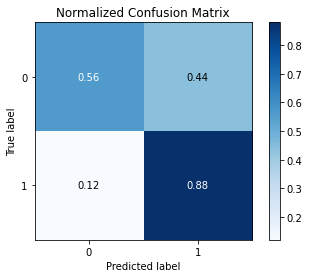

In [ ]:
# modelo final
xgb = XGBClassifier(learning_rate=0.001 , n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)
xgb.fit(X_train_rus, y_train_rus)

# fazer a previsão
X_test = scaler.transform(X_test)
y_pred = xgb.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

## Conclusões

Os dados de testes não haviam sido passados para o modelo ainda. No entanto, ele manteve um desempenho próximo àquele estimado anteriormente, graças a um bom trabalho de otimização nos parâmetros.

Como destacamos ao longo da análise, esta foi uma inplementação de Machine Learning com finalidades de estudo sendo assim, sabemos que ainda existe espaço para diversas outras técnicas de balanceamento, feature engineering, feature selection, tentativa de outros hiperparâmetros no XGboost e também uma ampliação na etapa de analise exploratória.

Entretanto acredito que o desempenho do modelo feita as ressalvas anteriores foi muito bom e pudemos observar o poder da otimização dos hiperparâmetros e também reforçar como é importante que se siga um encademento lógico para criar um algorítmo de Machine Learning.

Para uma implementação real, conseguimos visualizar como o aprendizado de máquina pode ser importante para a predição de situações de Churn e a partir dessa antecipação é a empresa pode tomar diversas ações para reter os clientes que como explicamos no início tem um custo muito menor que a aquisição de novos clientes.
 